# Анализ платежей и продуктов

## 1. Изучите распределение типов оплаты и их влияние на успешность сделок.

In [3]:
import pandas as pd

deals_df = pd.read_pickle("deals_cleaned_v3.pkl")

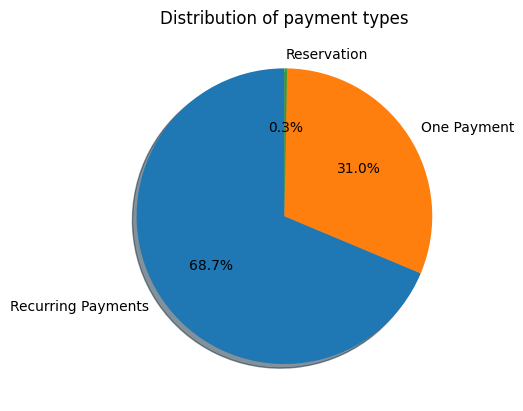

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out only successful deals and look on the Distribution of payment types
successful_deals_df = deals_df[(deals_df['Stage'] == 'Payment Done')]
s_payment_counts = successful_deals_df['Payment Type'].value_counts()

labels = s_payment_counts.index
sizes = s_payment_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Distribution of payment types")
plt.show()

In [ ]:
# successful_counts = deals_df[deals_df['Stage'] == 'Payment Done'].groupby('Payment Type').size()

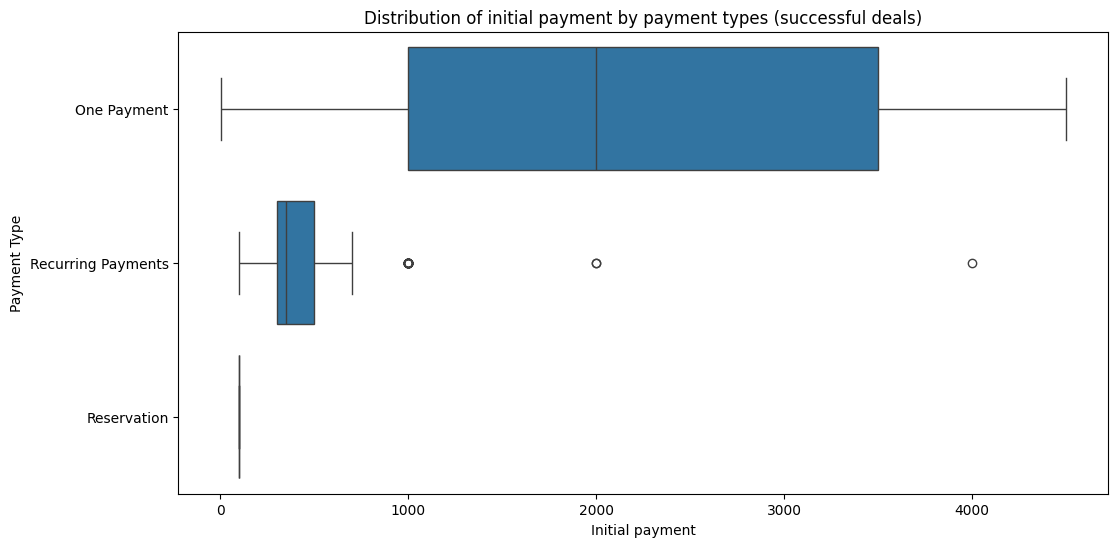

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='Initial Amount Paid', y='Payment Type', data=successful_deals_df, orient='h')
plt.title('Distribution of initial payment by payment types (successful deals)')
plt.xlabel('Initial payment')
plt.ylabel('Payment Type')
plt.show()

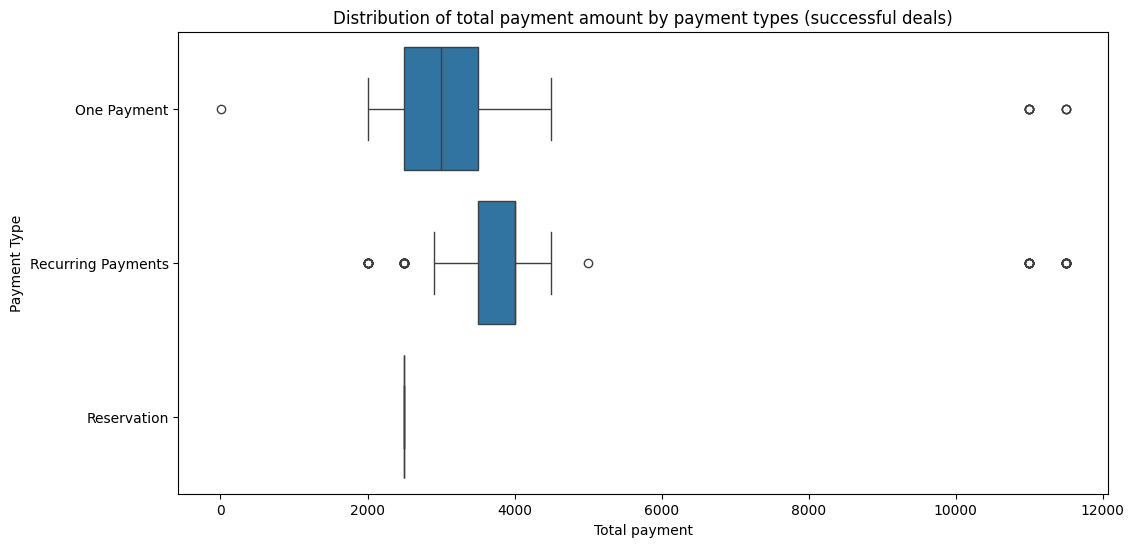

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='Offer Total Amount', y='Payment Type', data=successful_deals_df, orient='h')
plt.title('Distribution of total payment amount by payment types (successful deals)')
plt.xlabel('Total payment')
plt.ylabel('Payment Type')
plt.show()

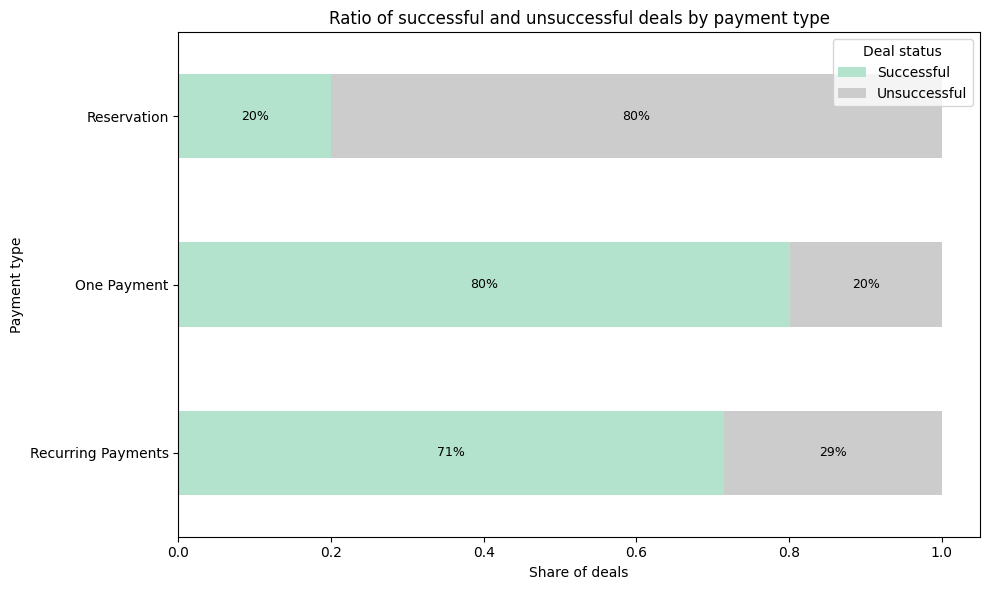

In [11]:
# Let's look at the ratio of successful and unsuccessful deals by payment type.

import matplotlib.pyplot as plt

# Filter out unsuccessful transactions
fail_counts = deals_df[deals_df['Stage'] != 'Payment Done']['Payment Type'].value_counts()

# Combine successful and unsuccessful deals
all_types = s_payment_counts.index.union(fail_counts.index)
stacked_df = pd.DataFrame({
    'Successful': s_payment_counts.reindex(all_types, fill_value=0),
    'Unsuccessful': fail_counts.reindex(all_types, fill_value=0)
})

# Shares
stacked_df_ratio = stacked_df.div(stacked_df.sum(axis=1), axis=0)

ax = stacked_df_ratio.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    colormap='Pastel2'
)

plt.title('Ratio of successful and unsuccessful deals by payment type')
plt.xlabel('Share of deals')
plt.ylabel('Payment type')
plt.legend(title='Deal status')

# Adding percentages to a chart
for i, (idx, row) in enumerate(stacked_df_ratio.iterrows()):
    left = 0
    for status in ['Successful', 'Unsuccessful']:
        value = row[status]
        if value > 0.02:  # Подписывать только сегменты больше 2%
            ax.text(left + value / 2, i, f"{value:.0%}", va='center', ha='center', fontsize=9)
        left += value

plt.tight_layout()
plt.show()

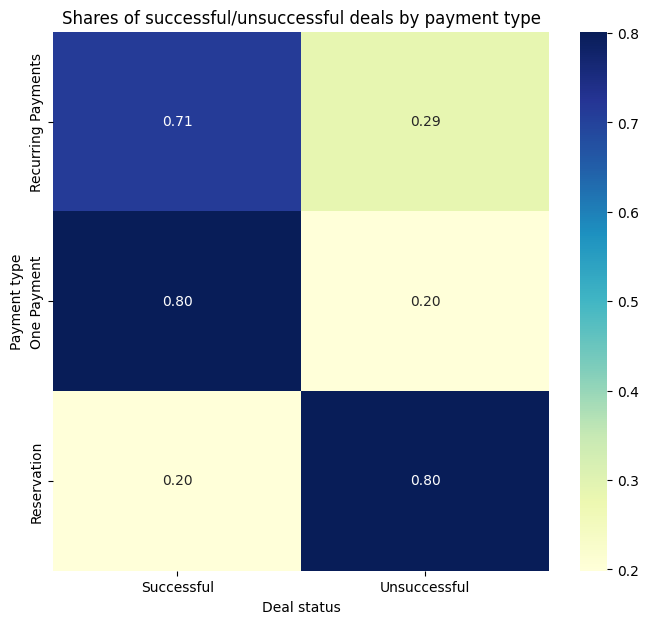

In [12]:
# Let's look at the hitmap for successful/unsuccessful transactions by payment type

heatmap_data = pd.DataFrame({
    'Successful': s_payment_counts,
    'Unsuccessful': fail_counts
}).fillna(0)

# convert it into fractions
heatmap_ratio = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

plt.figure(figsize=(8, 7))
sns.heatmap(heatmap_ratio, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Shares of successful/unsuccessful deals by payment type')
plt.xlabel('Deal status')
plt.ylabel('Payment type')
plt.show()

In [32]:
# Let's check if there is a statistical relationship between type of payment and the success of the deal
# H0 - There is no relationship between the type of payment and the success of the deal.
# H1 - There is relationship between the type of payment and the success of the deal.

from scipy.stats import chi2_contingency

contingency = pd.crosstab(deals_df['Payment Type'], deals_df['Stage'] == 'Payment Done')
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi² test p-value: {p:.4f}")

Chi² test p-value: 0.0036


## 2. Проанализируйте популярность и успешность различных продуктов и типов обучения.

In [13]:
# Popularity (number of deals) by products and types of training:
popularity_prod_type = deals_df.groupby(['Product', 'Education Type'], observed=False).size().reset_index(name='deal_count')
print(popularity_prod_type)

               Product Education Type  deal_count
0       Data Analytics        Evening           0
1       Data Analytics        Morning           0
2    Digital Marketing        Evening         250
3    Digital Marketing        Morning        1533
4  Find yourself in IT        Evening           0
5  Find yourself in IT        Morning           0
6         UX/UI Design        Evening         153
7         UX/UI Design        Morning         808
8        Web Developer        Evening           1
9        Web Developer        Morning         545


In [20]:
# Success (number of deals) by products and types of training:
successfully_prod_type = successful_deals_df.groupby(['Product', 'Education Type'], observed=True).size().reset_index(name='deal_count')
print(successfully_prod_type)

             Product Education Type  deal_count
0  Digital Marketing        Evening         113
1  Digital Marketing        Morning         354
2       UX/UI Design        Evening          58
3       UX/UI Design        Morning         171
4      Web Developer        Morning         137


In [15]:
# Popularity (number of deals) by products
popularity_prod = deals_df.groupby(['Product'], observed=False).size().reset_index(name='deal_count')
print(popularity_prod)

               Product  deal_count
0       Data Analytics           1
1    Digital Marketing        1990
2  Find yourself in IT           4
3         UX/UI Design        1022
4        Web Developer         575


In [27]:
# Success (number of deals) by products:
successfully_prod = successful_deals_df.groupby(['Product'], observed=True).size().reset_index(name='deal_count')
print(successfully_prod)

               Product  deal_count
0    Digital Marketing         474
1  Find yourself in IT           1
2         UX/UI Design         229
3        Web Developer         137


In [23]:
# Popularity (number of deals) by training types:
popularity_type = deals_df.groupby(['Education Type'], observed=False).size().reset_index(name='deal_count')
print(popularity_type)

  Education Type  deal_count
0        Evening         404
1        Morning        2895


In [16]:
# Success (number of deals) by training types
successfully_type = successful_deals_df.groupby(['Education Type'], observed=False).size().reset_index(name='deal_count')
print(successfully_type)

  Education Type  deal_count
0        Evening         171
1        Morning         662


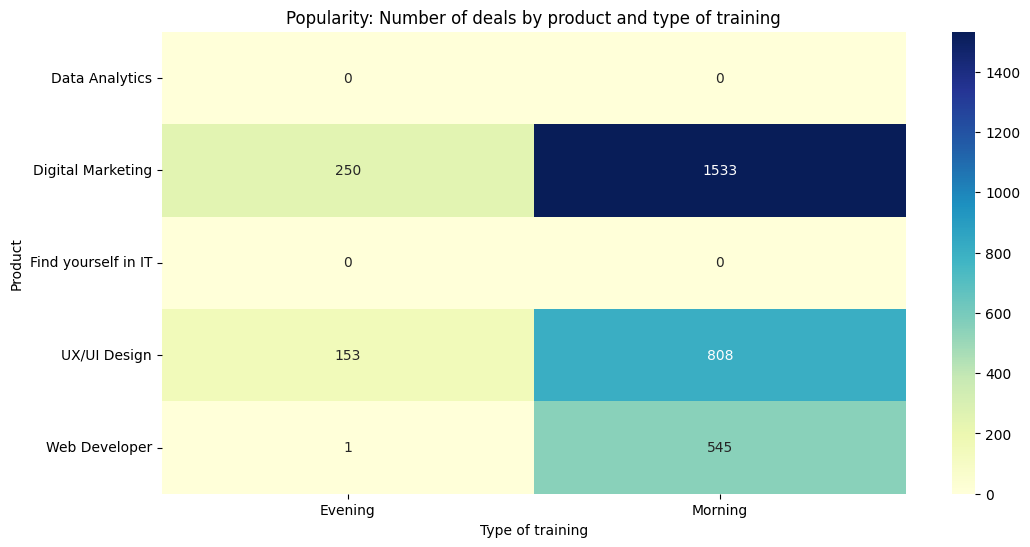

In [28]:
# Let's look at the hitmap for successful/unsuccessful deals by Product and Training type
pivot_popularity = popularity_prod_type.pivot(index='Product', columns='Education Type', values='deal_count').fillna(0) # Data Analytics does not appear on this chart, because the deal on it does not have a training type (in any case, its status is Lost)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_popularity, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Popularity: Number of deals by product and type of training')
plt.xlabel('Type of training')
plt.ylabel('Product')
plt.show()

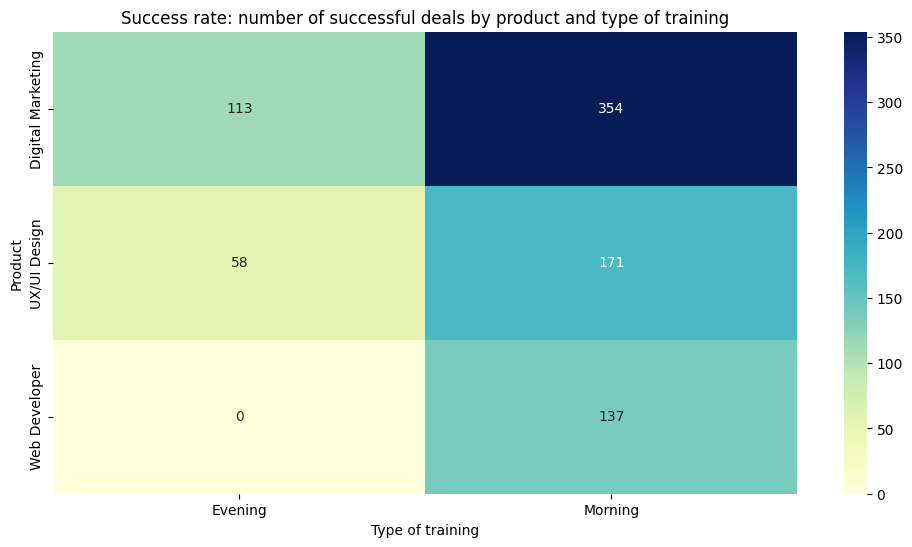

In [29]:
# Let's look at the hitmap for successful deals by product and type of training
pivot_successfully = successfully_prod_type.pivot(index='Product', columns='Education Type', values='deal_count').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_successfully, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Success rate: number of successful deals by product and type of training')
plt.xlabel('Type of training')
plt.ylabel('Product')
plt.show()

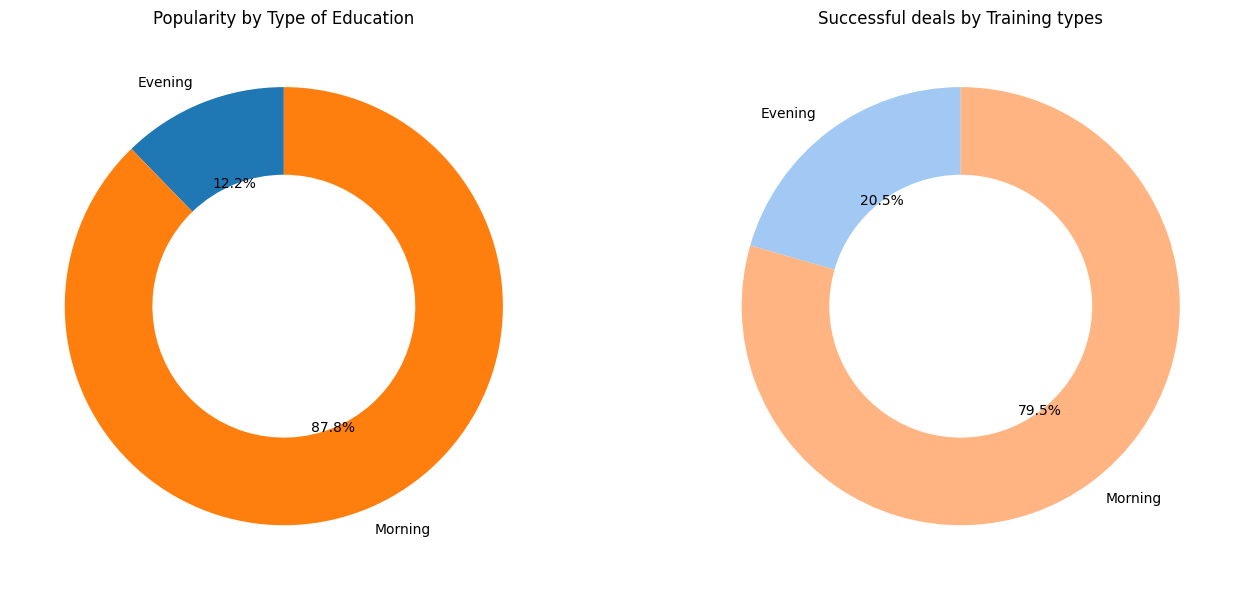

In [30]:
# Let's compare the number of popular (all deals) and successful deals by training types

import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Popularity (all deals)
axs[0].pie(popularity_type['deal_count'], labels=popularity_type['Education Type'],
           autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
axs[0].set_title('Popularity by Type of Education')

# Successful (successful deals)
axs[1].pie(successfully_type['deal_count'], labels=successfully_type['Education Type'],
           autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=sns.color_palette('pastel'))
axs[1].set_title('Successful deals by Training types')

plt.tight_layout()
plt.show()

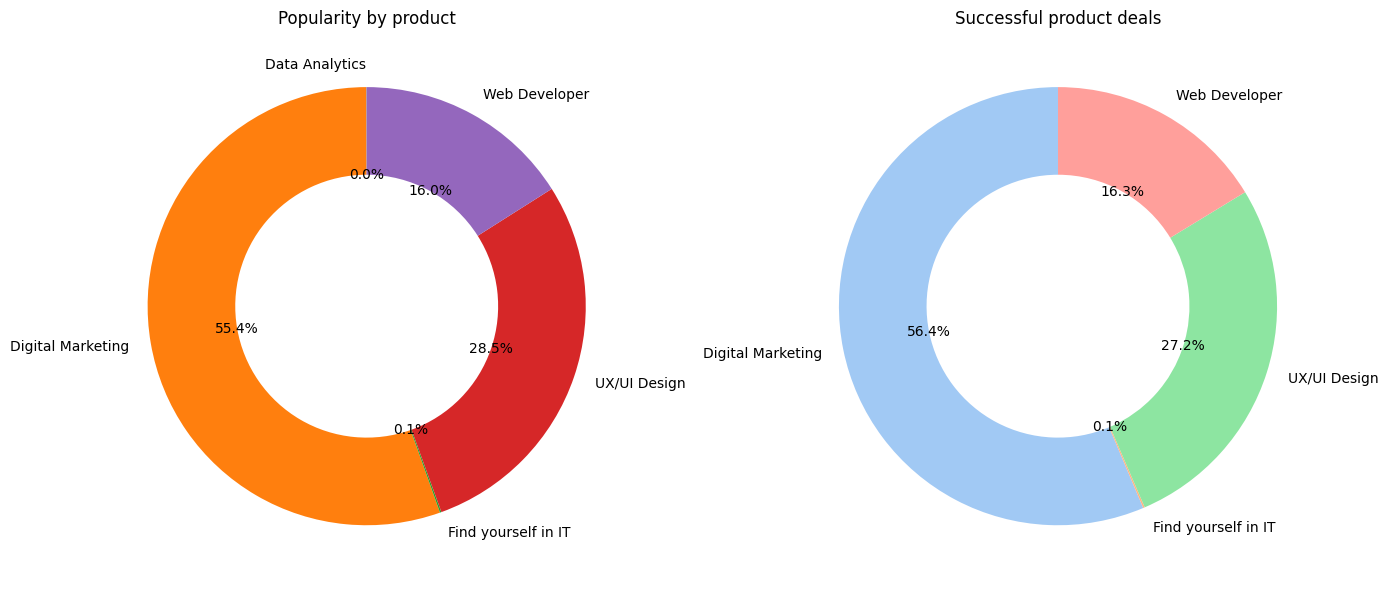

In [31]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Popularity (all deals)
axs[0].pie(popularity_prod['deal_count'], labels=popularity_prod['Product'],
           autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
axs[0].set_title('Popularity by product')

# Successful (successful deals)
axs[1].pie(successfully_prod['deal_count'], labels=successfully_prod['Product'],
           autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=sns.color_palette('pastel'))
axs[1].set_title('Successful product deals')

plt.tight_layout()
plt.show()